<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center> Тема 6. Задача восстановления регрессии</center>
## <center>Lasso- и Ridge-регрессия</center>

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from cycler import cycler
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge

**Будем работать с набором данных по ценам на дома в Бостоне (репозиторий UCI).**
**Загружаем данные.**

In [2]:
boston = load_boston()
X, y = boston['data'], boston['target']

**Почитаем описание набора данных:**

In [3]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

**Признаки:**
- CRIM - количество преступлений на душу населения
- ZN - процент жилых участков площадью больше 25 тыс. кв. футов (~ 23 сотки)
- INDUS - процент площадей под оптовую торговлю 
- CHAS - протекает ли река
- NOX - концентрация оксидов азота
- RM - среднее число комнат в здании
- AGE - доля зданий, построенных до 1940 года 
- DIS - взвешенное расстояние до 5 деловых центров Бостона
- RAD - индекс доступности скоростных магистралей
- TAX - уровень налогов
- PTRATIO - среднее число учащихся на одного преподавателя 
- B - процент афроамериканцев
- LSTAT - процент граждан с низким уровнем жизни
- MEDV (целевой) - медианная стоимости домов в районе

In [4]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

**Посмотрим на первые 2 записи.**

In [5]:
X[:2]

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, 0.0000e+00, 5.3800e-01,
        6.5750e+00, 6.5200e+01, 4.0900e+00, 1.0000e+00, 2.9600e+02,
        1.5300e+01, 3.9690e+02, 4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, 0.0000e+00, 4.6900e-01,
        6.4210e+00, 7.8900e+01, 4.9671e+00, 2.0000e+00, 2.4200e+02,
        1.7800e+01, 3.9690e+02, 9.1400e+00]])

## Lasso-регрессия

Lasso-регрессия решает задачу минимизации среднеквардатичной ошибки с L1-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d |w_i|$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

**Обучим Lasso-регрессию с небольшим коэффициентом $\alpha$ (слабая регуляризация). Обнуляется только коэффициент при признаке NOX (концентрация оксидов азота). Значит, он наименее важен для предсказания целевого признака – медианной стоимости домов в районе.**

In [7]:
lasso = Lasso(alpha=0.1)
lasso.fit(X,y)
lasso.coef_

array([-0.09789363,  0.04921111, -0.03661906,  0.95519003, -0.        ,
        3.70320175, -0.01003698, -1.16053834,  0.27470721, -0.01457017,
       -0.77065434,  0.01024917, -0.56876914])

**Обучим Lasso-регрессию с коэффициентом $\alpha=10$. Теперь ненулевые коэффициенты остались только при признаках ZN (процент жилых участков площадью больше 25 тыс. кв. футов), TAX (уровень налогов), B (процент афроамериканцев) и LSTAT (процент граждан с низким уровнем жизни).**

In [8]:
lasso = Lasso(alpha=10)
lasso.fit(X,y)
lasso.coef_

array([-0.        ,  0.02614602, -0.        ,  0.        ,  0.        ,
        0.        ,  0.        , -0.        ,  0.        , -0.00928242,
       -0.        ,  0.00749584, -0.56403807])

**Таким образом, Lasso-регрессия служит методом отбора признаков.**

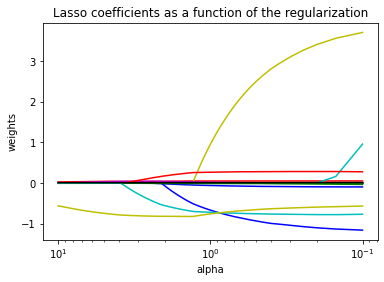

In [9]:
n_alphas = 200
alphas = np.linspace(0.1, 10, n_alphas)
model = Lasso()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)
    
ax = plt.gca()
ax.set_prop_cycle(cycler('color', 
                          ['b', 'r', 'g', 'c', 'k', 'y', 'm']))

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show();

**Теперь определим лучшее значение $\alpha$ в процессе кросс-валидации.**

In [10]:
lasso_cv = LassoCV(alphas=alphas, 
                   cv=3, random_state=17)
lasso_cv.fit(X, y)

LassoCV(alphas=array([ 0.1       ,  0.14974874,  0.19949749,  0.24924623,  0.29899497,
        0.34874372,  0.39849246,  0.44824121,  0.49798995,  0.54773869,
        0.59748744,  0.64723618,  0.69698492,  0.74673367,  0.79648241,
        0.84623116,  0.8959799 ,  0.94572864,  0.99547739,  1.04522613,
        1.09497487,  1.14472362,  1.19447236,  1.24422111,  1.29396985,
        1.34371859,  1.39346734,  1.44321608,  1.49296482,  1.54271357,
        1.5924...
        8.30854271,  8.35829146,  8.4080402 ,  8.45778894,  8.50753769,
        8.55728643,  8.60703518,  8.65678392,  8.70653266,  8.75628141,
        8.80603015,  8.85577889,  8.90552764,  8.95527638,  9.00502513,
        9.05477387,  9.10452261,  9.15427136,  9.2040201 ,  9.25376884,
        9.30351759,  9.35326633,  9.40301508,  9.45276382,  9.50251256,
        9.55226131,  9.60201005,  9.65175879,  9.70150754,  9.75125628,
        9.80100503,  9.85075377,  9.90050251,  9.95025126, 10.        ]),
        cv=3, random_state=17

In [11]:
lasso_cv.coef_

array([-0.09739888,  0.04946381, -0.02749478,  0.16060406, -0.        ,
        3.55971374, -0.00726968, -1.13393157,  0.28096773, -0.01503453,
       -0.77985441,  0.01025033, -0.58259584])

In [12]:
lasso_cv.alpha_

0.14974874371859298

**Метод `cross_val_score` максимизирует метрику, так что вместо 
минимизации MSE сделаем максимизацию отрицательного MSE – `neg_mean_squared_error`.**

In [13]:
cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, 
                scoring='neg_mean_squared_error')

array([-16.89312641, -37.56646167, -72.42092752])

**Чтобы все-таки трактовать результат в терминах MSE, выведем модуль среднего значения метрики `neg_mean_squared_error` на кросс-валидации.**

In [14]:
abs(np.mean(cross_val_score(Lasso(lasso_cv.alpha_), X, y, cv=3, 
                        scoring='neg_mean_squared_error')))

42.29350519915075

In [15]:
abs(np.mean(cross_val_score(Lasso(9.95), X, y, cv=3 , scoring='neg_mean_squared_error')))

53.72266087715847

**Еще один неоднозначный момент: LassoCV сортирует значения параметров по убыванию – так проще оптимизировать. Из-за этого может показаться, что оптимизация параметра $\alpha$ работает неправильно**

In [16]:
lasso_cv.alphas[:10] # значения параметров на входе

array([0.1       , 0.14974874, 0.19949749, 0.24924623, 0.29899497,
       0.34874372, 0.39849246, 0.44824121, 0.49798995, 0.54773869])

In [17]:
lasso_cv.alphas_[:10] # преобразованные значения параметров

array([10.        ,  9.95025126,  9.90050251,  9.85075377,  9.80100503,
        9.75125628,  9.70150754,  9.65175879,  9.60201005,  9.55226131])

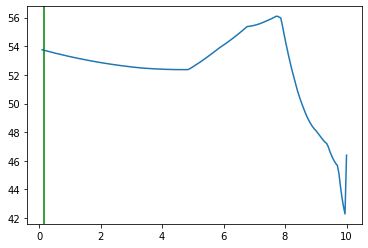

In [18]:
plt.plot(lasso_cv.alphas, lasso_cv.mse_path_.mean(1)) # неверно
plt.axvline(lasso_cv.alpha_, c='g');

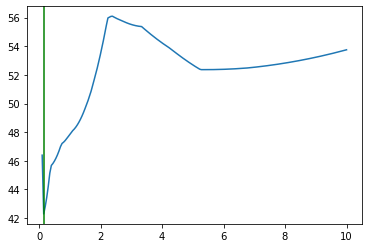

In [19]:
plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(1)) # верно
plt.axvline(lasso_cv.alpha_, c='g');

## Ridge-регрессия

Ridge-регрессия (или гребневая регрессия) решает задачу минимизации среднеквардатичной ошибки с L2-регуляризацией:
$$\Large error(X, y, w) = \frac{1}{2} \sum_{i=1}^\ell {(y_i - w^Tx_i)}^2 + \alpha \sum_{i=1}^d w_i^2$$

где $y = w^Tx$ – уравнение гиперплоскости, зависящее от параметров модели $w$, $\ell$-число объектов в выборке $X$, $d$ – число признаков, $y$ – значения целевого признака, $\alpha$ – коэффициент регуляризации.

В sklearn реализован специальный класс [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) для кросс-валидации с Ridge-регрессией.

In [20]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)

In [21]:
ridge_cv = RidgeCV(alphas=ridge_alphas, 
                   scoring='neg_mean_squared_error',
                   cv=3)
ridge_cv.fit(X, y)

RidgeCV(alphas=array([1.00000000e-02, 1.09698580e-02, 1.20337784e-02, 1.32008840e-02,
       1.44811823e-02, 1.58856513e-02, 1.74263339e-02, 1.91164408e-02,
       2.09704640e-02, 2.30043012e-02, 2.52353917e-02, 2.76828663e-02,
       3.03677112e-02, 3.33129479e-02, 3.65438307e-02, 4.00880633e-02,
       4.39760361e-02, 4.82410870e-02, 5.29197874e-02, 5.80522552e-02,
       6.36824994e-02, 6.98587975e-0...
       1.18953407e+05, 1.30490198e+05, 1.43145894e+05, 1.57029012e+05,
       1.72258597e+05, 1.88965234e+05, 2.07292178e+05, 2.27396575e+05,
       2.49450814e+05, 2.73644000e+05, 3.00183581e+05, 3.29297126e+05,
       3.61234270e+05, 3.96268864e+05, 4.34701316e+05, 4.76861170e+05,
       5.23109931e+05, 5.73844165e+05, 6.29498899e+05, 6.90551352e+05,
       7.57525026e+05, 8.30994195e+05, 9.11588830e+05, 1.00000000e+06]),
        cv=3, scoring='neg_mean_squared_error')

In [22]:
ridge_cv.alpha_

264.30814869741084

**В случае Ridge-регрессии никакие праметры не зануляются – они могут быть очень малыми, но не нулевыми.**

In [23]:
ridge_cv.coef_

array([-0.09975818,  0.05562804, -0.05006572,  0.30202744, -0.09151777,
        1.42295311,  0.01289136, -0.99866364,  0.33080392, -0.01661515,
       -0.81984784,  0.00876309, -0.72318342])

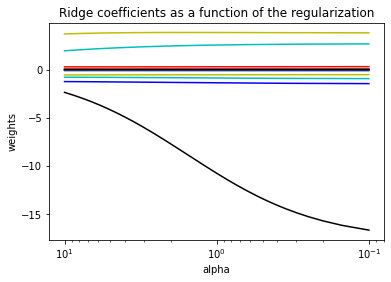

In [24]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 6, n_alphas)
model = Ridge()

coefs = []
for a in alphas:
    model.set_params(alpha=a)
    model.fit(X, y)
    coefs.append(model.coef_)
    
ax = plt.gca()
ax.set_prop_cycle(cycler('color', 
                         ['b', 'r', 'g', 'c', 'k', 'y', 'm']))

ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

## Ссылки
- [Обощеннные линейные модели](http://scikit-learn.org/stable/modules/linear_model.html) (Generalized Linear Models, GLM) в Scikit-learn
- [LinearRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression), [Lasso](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso), [LassoCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html#sklearn.linear_model.LassoCV), [Ridge](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html) и [RidgeCV](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html#sklearn.linear_model.RidgeCV) в Scikit-learn
- [Статья](https://habrahabr.ru/post/264915/) "Методы отбора фич" на Хабрахабре с упоминанием Lasso-регрессии 